In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import numpy as np
import pandas as pd

# Data Exploration

## Read data

In [2]:
DATASET_PATH = '/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train'

# List all labels
labels = sorted([d for d in os.listdir(DATASET_PATH) if os.path.isdir(os.path.join(DATASET_PATH, d))])
print(f"Found {len(labels)} classes: {labels}")

label_counts = {label: len(os.listdir(os.path.join(DATASET_PATH, label))) for label in labels}

# Top 5 popular labels
for label, count in list(label_counts.items())[:5]:
    print(f"{label}: {count} images")

Found 29 classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']
A: 3000 images
B: 3000 images
C: 3000 images
D: 3000 images
E: 3000 images


## Distribution of num. of imgs per label

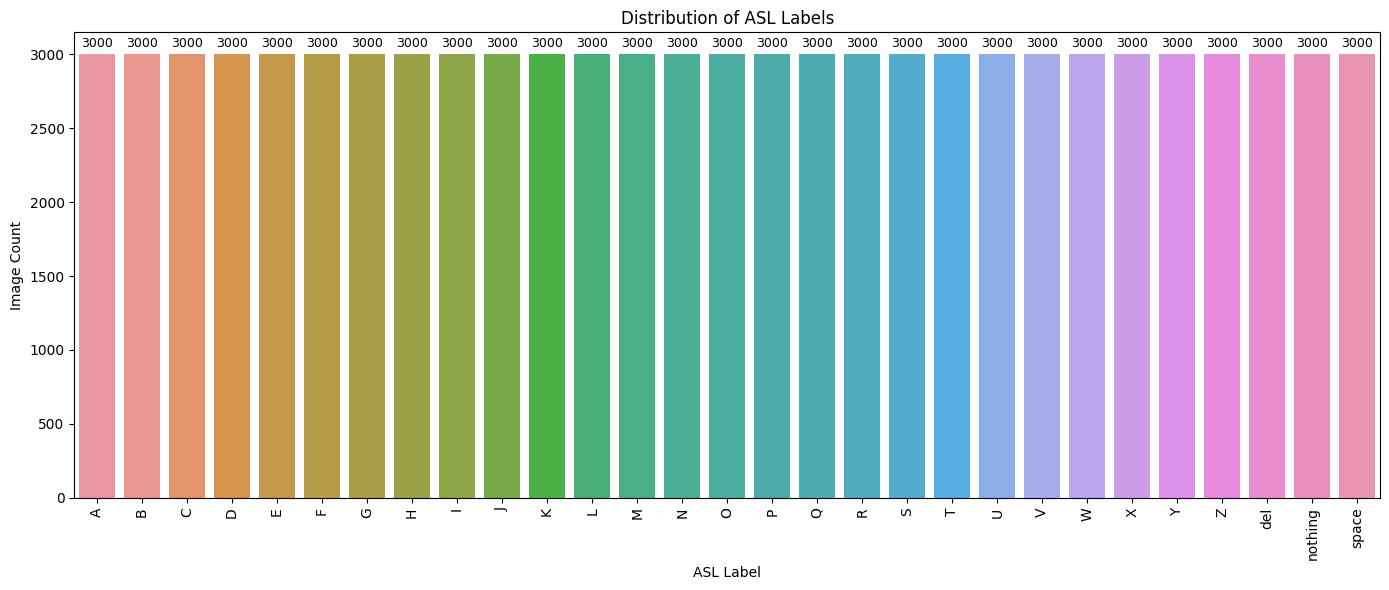

In [3]:
sorted_labels = sorted(label_counts.items(), key=lambda x: x[1], reverse=True)
labels = [label for label, count in sorted_labels]
counts = [count for label, count in sorted_labels]

df = pd.DataFrame({'ASL Label': labels, 'Image Count': counts})

plt.figure(figsize=(14, 6))
ax = sns.barplot(data=df, x='ASL Label', y='Image Count')
plt.xticks(rotation=90)
plt.title('Distribution of ASL Labels')
plt.xlabel('ASL Label')
plt.ylabel('Image Count')

for i, bar in enumerate(ax.patches):
    height = bar.get_height()
    ax.annotate(f'{int(height)}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # offset
                textcoords="offset points",
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

## A sample of each label

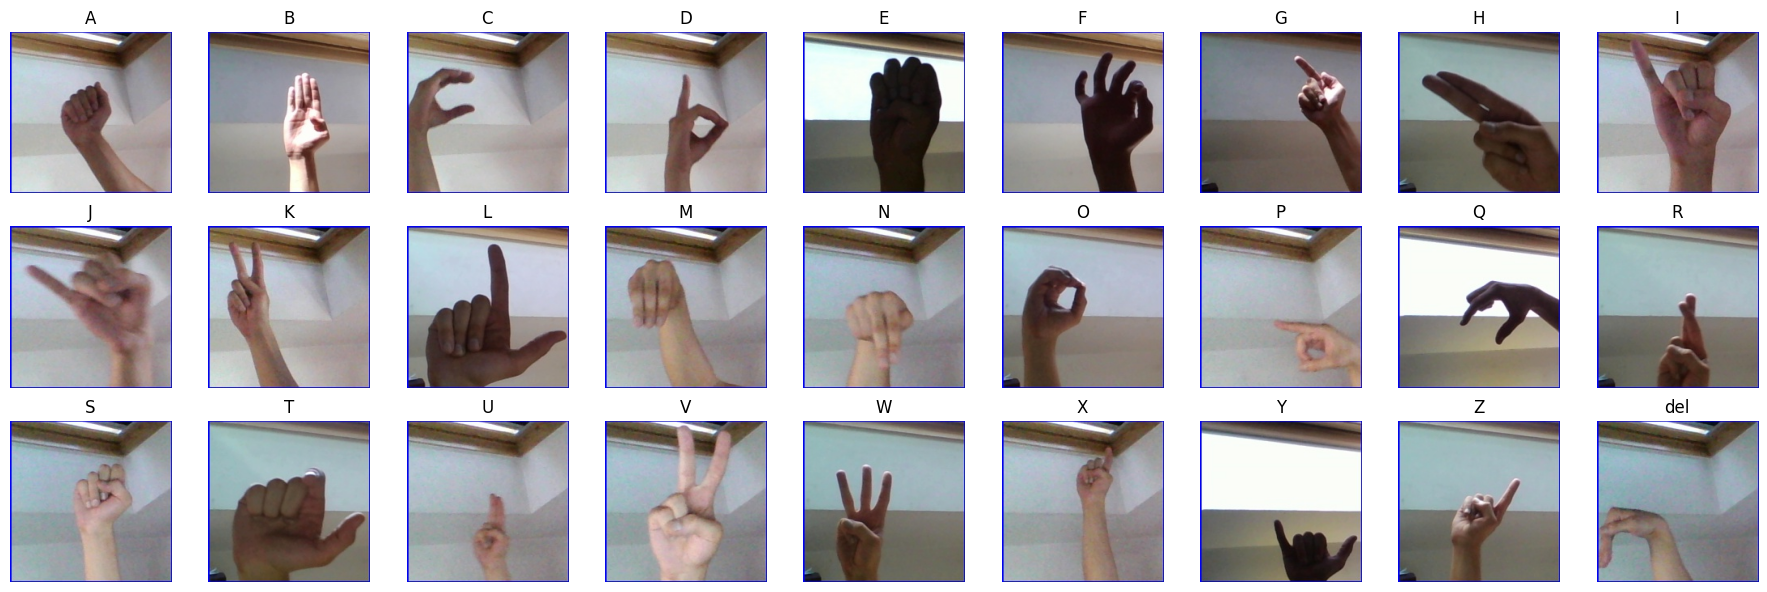

In [4]:
def plot_sample_images(n_rows=3, n_cols=9):
    plt.figure(figsize=(18, 6))
    for i in range(n_rows * n_cols):
        label = labels[i]
        img_path = os.path.join(DATASET_PATH, label, os.listdir(os.path.join(DATASET_PATH, label))[0])
        img = Image.open(img_path)
        plt.subplot(n_rows, n_cols, i+1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_sample_images()

## Split to train - val - test (0.7 - 0.15 - 0.15)

In [5]:
import os
import shutil
import random
from sklearn.model_selection import train_test_split

"""
    Split the dataset from source_dir into train, validation, and test sets
    with the given train_ratio, val_ratio, and the remaining for test.
"""
def split_dataset(source_dir, train_dir, val_dir, test_dir, train_ratio, val_ratio):
    # Create destination directories if they don't exist
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)
    
    # Get subdirectories in source_dir (each subdirectory corresponds to a class)
    classes = [d for d in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, d))]
    
    for cls in classes:
        # Create class subdirectories in the destination folders
        os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
        os.makedirs(os.path.join(val_dir, cls), exist_ok=True)
        os.makedirs(os.path.join(test_dir, cls), exist_ok=True)
        
        # Get all image files in the class directory
        files = [f for f in os.listdir(os.path.join(source_dir, cls)) 
                if f.endswith('.jpg') or f.endswith('.png') or f.endswith('.jpeg')]
        
        # Shuffle for randomness
        random.shuffle(files)
        
        # Split into 3 sets
        train_files, temp_files = train_test_split(files, train_size=train_ratio, random_state=42)
        
        # Split temp_files into val and test to ensure global val ratio
        val_ratio_adjusted = val_ratio / (1 - train_ratio)
        
        val_files, test_files = train_test_split(temp_files, train_size=val_ratio_adjusted, random_state=42)
        
        # Copy files to corresponding folders
        for f in train_files:
            shutil.copy2(os.path.join(source_dir, cls, f), os.path.join(train_dir, cls, f))
        
        for f in val_files:
            shutil.copy2(os.path.join(source_dir, cls, f), os.path.join(val_dir, cls, f))
        
        for f in test_files:
            shutil.copy2(os.path.join(source_dir, cls, f), os.path.join(test_dir, cls, f))
        
        print(f"Class {cls} split: {len(train_files)} train images, {len(val_files)} validation images, {len(test_files)} test images")

# Directory
source_dir = "/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train"
output_dir = "/kaggle/working/asl_split"

train_dir = os.path.join(output_dir, "train")
val_dir = os.path.join(output_dir, "val")
test_dir = os.path.join(output_dir, "test")

# Call function
split_dataset(source_dir, train_dir, val_dir, test_dir, train_ratio=0.7, val_ratio=0.15)

# Count number of images in each set
def count_images(directory):
    total = 0
    for root, _, files in os.walk(directory):
        for f in files:
            if f.endswith('.jpg') or f.endswith('.png') or f.endswith('.jpeg'):
                total += 1
    return total

print("\nTotal number of images:")
print(f"Train: {count_images(train_dir)}")
print(f"Validation: {count_images(val_dir)}")
print(f"Test: {count_images(test_dir)}")

Class N split: 2100 train images, 449 validation images, 451 test images
Class R split: 2100 train images, 449 validation images, 451 test images
Class space split: 2100 train images, 449 validation images, 451 test images
Class B split: 2100 train images, 449 validation images, 451 test images
Class I split: 2100 train images, 449 validation images, 451 test images


KeyboardInterrupt: 

# Model

## Libs + paths configuration

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim.lr_scheduler as lr_scheduler
import timm
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics.pairwise import cosine_similarity
import pickle
import string
import seaborn as sns

In [7]:
# Check GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set up paths
data_dir = "/kaggle/working/asl_split" 
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
test_dir = os.path.join(data_dir, "test")

# Check number of classes
num_classes = len(os.listdir(train_dir))
print(f"Number of classes: {num_classes}")

Using device: cuda
Number of classes: 29


## Hyperparams

In [8]:
# Set hyperparameters
# Model requires 224x224 input size image since pretrained on ImageNet1K
BATCH_SIZE = 32
NUM_CLASSES = 29
NUM_EPOCHS = 20
INPUT_SIZE = 224

In [9]:
# Define image transformations
# Use data augmentation for training set
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.3),                 
    transforms.RandomRotation(degrees=15),                  
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.95, 1.05)),  
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.05),  
    transforms.RandomGrayscale(p=0.03),                    
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset = datasets.ImageFolder(val_dir, transform=val_test_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=val_test_transforms)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# Display dataset info
print(f"Number of training images: {len(train_dataset)}")
print(f"Number of validation images: {len(val_dataset)}")
print(f"Number of test images: {len(test_dataset)}")
print(f"Class names: {train_dataset.classes}")

Number of training images: 64665
Number of validation images: 14951
Number of test images: 15038
Class names: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


## EfficientNet-B0 + KNN

In [20]:
class SLR:
    def __init__(self, num_classes=NUM_CLASSES, input_shape=(INPUT_SIZE, INPUT_SIZE)):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model = None
        self.transform = transforms.Compose([
            transforms.Resize(input_shape),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        
        # Few-shot learning components
        self.knn = KNeighborsClassifier(n_neighbors=5, weights='distance', metric='cosine')
        self.few_shot_embeddings = {}
        self.few_shot_labels = []

    ################## build() #######################
    def build_model(self):
        """EfficientNet-B0 model for fine-tuning"""
        model = timm.create_model('efficientnet_b0', pretrained=True)
        
        # Freeze toàn bộ trước
        for param in model.parameters():
            param.requires_grad = False
    
        # Unfreeze last layers of backbone
        for name, param in model.named_parameters():
            if any(x in name for x in ['blocks.6', 'conv_head', 'bn2']):  # just finetune last layers
                param.requires_grad = True
    
        # Replace final classifier
        num_feas = model.classifier.in_features
        model.classifier = nn.Linear(num_feas, self.num_classes)
        model.classifier.requires_grad = True  # classifier luôn phải train
    
        self.model = model.to(self.device)
        print("Model built: backbone partially unfrozen.")
        return self.model

    ################## ext_features() #######################
    def extract_features(self, img):
        """Extract features from an image using the backbone"""
        # Ensure model is in eval mode for feature extraction
        self.model.eval()
        
        # Preprocess the image
        if isinstance(img, str):
            img = Image.open(img).convert('RGB')
        elif isinstance(img, np.ndarray):
            img = Image.fromarray(img.astype('uint8')).convert('RGB')
        
        img_tensor = self.transform(img).unsqueeze(0).to(self.device)
        
        # Extract features - we'll use the penultimate layer
        with torch.inference_mode():
            # Register a forward hook to get features from the penultimate layer
            features = []
            def hook_fn(module, input, output):
                features.append(output)
            
            # Attach the hook to the global pooling layer
            hook = self.model.global_pool.register_forward_hook(hook_fn)
            
            # Forward pass
            _ = self.model(img_tensor)
            
            # Remove the hook
            hook.remove()
            
            # Get the features
            return features[0].squeeze().cpu().numpy()
            
    ################## add_few_shot() #######################
    def add_few_shot_sample(self, image, label):
        """Add a new few-shot sample for a custom gesture"""
        features = self.extract_features(image)
        
        if label in self.few_shot_embeddings:
            self.few_shot_embeddings[label].append(features)
        else:
            self.few_shot_embeddings[label] = [features]
            self.few_shot_labels.append(label)
            
        # Retrain KNN whenever new samples are added
        self._update_few_shot_model()
        
        return True
        
    ################## update() #######################
    def _update_few_shot_model(self):
        """Update the few-shot learning model with the current embeddings"""
        all_embeddings = []
        all_labels = []
        
        for label, embeddings in self.few_shot_embeddings.items():
            for emb in embeddings:
                all_embeddings.append(emb)
                all_labels.append(label)
                
        if len(all_embeddings) > 0:
            X = np.array(all_embeddings)
            y = np.array(all_labels)
            self.knn.fit(X, y)
            
    ################## predict() #######################
    def predict(self, img, include_few_shot=True, confidence_threshold=0.7):
        """
        Predict the class for an image.
        Returns: {'label': ..., 'confidence': ..., 'source': 'standard' | 'few-shot'}
        """
        self.model.eval()
    
        # Preprocess the image
        if isinstance(img, str):
            img = Image.open(img).convert('RGB')
        elif isinstance(img, np.ndarray):
            img = Image.fromarray(img.astype('uint8')).convert('RGB')
    
        img_tensor = self.transform(img).unsqueeze(0).to(self.device)
    
        # Extract features for few-shot
        features = self.extract_features(img)
    
        # Standard model prediction
        with torch.inference_mode():
            outputs = self.model(img_tensor)
            probabilities = F.softmax(outputs, dim=1)[0].cpu().numpy()
    
        standard_class_idx = int(np.argmax(probabilities))
        standard_confidence = float(probabilities[standard_class_idx])
    
        # If no few-shot or not enabled, return standard prediction
        if not include_few_shot or not self.few_shot_labels:
            return {
                'label': standard_class_idx,
                'confidence': standard_confidence,
                'source': 'standard'
            }
    
        # Few-shot KNN prediction
        few_shot_pred = self.knn.predict([features])[0]
        distances, _ = self.knn.kneighbors([features], n_neighbors=min(3, len(self.knn.n_samples_)))
        similarities = 1 - distances[0]
        avg_similarity = float(np.mean(similarities))
    
        # Compare and select best source
        if avg_similarity > confidence_threshold and avg_similarity > standard_confidence:
            return {
                'label': few_shot_pred,
                'confidence': avg_similarity,
                'source': 'few-shot'
            }
        else:
            return {
                'label': standard_class_idx,
                'confidence': standard_confidence,
                'source': 'standard'
            }
            
    ################## save() #######################
    def save(self, model_path, few_shot_path=None):
        dir_path = os.path.dirname(model_path)
        if dir_path and not os.path.exists(dir_path):
            os.makedirs(dir_path, exist_ok=True)
        
        torch.save(self.model.state_dict(), model_path)
        
        if few_shot_path:
            few_shot_dir = os.path.dirname(few_shot_path)
            if few_shot_dir and not os.path.exists(few_shot_dir):
                os.makedirs(few_shot_dir, exist_ok=True)
            
            few_shot_data = {
                'embeddings': self.few_shot_embeddings,
                'labels': self.few_shot_labels
            }
            with open(few_shot_path, 'wb') as f:
                pickle.dump(few_shot_data, f)

    ################## load() #######################
    def load(self, model_path, few_shot_path=None):
        """Load the model and few-shot embeddings"""
        # Build model architecture if not already built
        if self.model is None:
            self.build_model()
            
        # Load model weights
        self.model.load_state_dict(torch.load(model_path, map_location=self.device))
        self.model.eval()
        
        # Load few-shot data if exists
        if few_shot_path and os.path.exists(few_shot_path):
            with open(few_shot_path, 'rb') as f:
                few_shot_data = pickle.load(f)
                self.few_shot_embeddings = few_shot_data['embeddings']
                self.few_shot_labels = few_shot_data['labels']
                
            # Update the KNN model with loaded embeddings
            self._update_few_shot_model()

    ################## plot() #######################
    def _plot_training_history(self, history):
        epochs = range(1, len(history['train_loss']) + 1)
        plt.figure(figsize=(12, 5))
    
        # Loss
        plt.subplot(1, 2, 1)
        plt.plot(epochs, history['train_loss'], label='Train Loss')
        plt.plot(epochs, history['val_loss'], label='Val Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss Over Epochs')
        plt.legend()
    
        # Accuracy
        plt.subplot(1, 2, 2)
        plt.plot(epochs, history['train_acc'], label='Train Accuracy')
        plt.plot(epochs, history['val_acc'], label='Val Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Accuracy Over Epochs')
        plt.legend()
    
        plt.tight_layout()
        plt.show()

    ################## evaluate() #######################
    def evaluate_model(self, loader, split_name):
        """
        Evaluate model on dataset (val/test), print confusion matrix and classification report
        """
        self.model.eval()
        all_preds = []
        all_labels = []
    
        if self.num_classes == 29:
            class_names = list(string.ascii_uppercase) + ['del', 'nothing', 'space']
        else:
            class_names = list(string.ascii_uppercase)[:self.num_classes]
    
        with torch.inference_mode():
            for inputs, labels in loader:
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)
                outputs = self.model(inputs)
                _, preds = torch.max(outputs, 1)
    
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
    
        # Confusion matrix
        cm = confusion_matrix(all_labels, all_preds)
        plt.figure(figsize=(12, 10))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names, yticklabels=class_names)
        plt.title(f"{split_name} Confusion Matrix")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.show()
    
        # Classification report
        print(f"\n{split_name} Classification Report:")
        print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))

    ################## train() #######################
    def train_model(self, train_loader, val_loader, epochs=10, lr=0.001, patience=3, warmup_epochs=3):
        """
        Train the model with early stopping, plotting, and warm-up
        """
        self.model.train()
    
        # Loss with label smoothing
        criterion = nn.CrossEntropyLoss()
    
        # Optimizer with weight decay (L2 regularization)
        optimizer = torch.optim.AdamW(
            filter(lambda p: p.requires_grad, self.model.parameters()),
            lr=lr,
            weight_decay=1e-5
        )
    
        # Warm-up scheduler: increase LR linearly from lr/10 to lr over warmup_epochs
        warmup_scheduler = lr_scheduler.LinearLR(
            optimizer, start_factor=0.1, end_factor=1.0, total_iters=warmup_epochs * len(train_loader)
        )
    
        # Main scheduler after warm-up
        main_scheduler = lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=3, min_lr=1e-6
        )
    
        best_val_acc = 0
        best_model_wts = None
        early_stop_counter = 0
    
        # Store loss/accuracy history for visualization
        history = {
            'train_loss': [], 'train_acc': [],
            'val_loss': [], 'val_acc': [],
            'log': []
        }
    
        for epoch in range(epochs):
            running_loss = 0.0
            running_corrects = 0
    
            # Add tqdm progress bar for training
            train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]")
            for inputs, labels in train_pbar:
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)
    
                optimizer.zero_grad()
                outputs = self.model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                loss.backward()
                
                # Add gradient clipping to prevent exploding gradients
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                optimizer.step()
    
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
    
                # Update progress bar description with current loss
                train_pbar.set_postfix(loss=f"{loss.item():.4f}")
    
                # Step warm-up scheduler during warm-up phase
                if epoch < warmup_epochs:
                    warmup_scheduler.step()
    
            # Compute training metrics
            epoch_loss = running_loss / len(train_loader.dataset)
            epoch_acc = running_corrects.double() / len(train_loader.dataset)
            history['train_loss'].append(epoch_loss)
            history['train_acc'].append(epoch_acc.item())
    
            # Validation phase
            self.model.eval()
            val_loss = 0.0
            val_corrects = 0
    
            # Add tqdm progress bar for validation
            with torch.inference_mode():
                val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]")
                for inputs, labels in val_pbar:
                    inputs = inputs.to(self.device)
                    labels = labels.to(self.device)
                    outputs = self.model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
    
                    val_loss += loss.item() * inputs.size(0)
                    val_corrects += torch.sum(preds == labels.data)
    
                    # Update progress bar description with current loss
                    val_pbar.set_postfix(loss=f"{loss.item():.4f}")
    
            val_epoch_loss = val_loss / len(val_loader.dataset)
            val_epoch_acc = val_corrects.double() / len(val_loader.dataset)
            history['val_loss'].append(val_epoch_loss)
            history['val_acc'].append(val_epoch_acc.item())
    
            # Store metrics for this epoch
            history['log'].append({
                'epoch': epoch + 1,
                'train_loss': epoch_loss,
                'train_acc': epoch_acc.item(),
                'val_loss': val_epoch_loss,
                'val_acc': val_epoch_acc.item()
            })
    
            # Adjust learning rate with main scheduler after warm-up
            if epoch >= warmup_epochs:
                main_scheduler.step(val_epoch_loss)
    
            # Print to console
            current_lr = optimizer.param_groups[0]['lr']
            print(f"Epoch {epoch+1}/{epochs} - "
                  f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f} | "
                  f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f} | "
                  f"Learning Rate: {current_lr:.6f}", flush=True)
    
            # Early stopping check
            if val_epoch_acc > best_val_acc:
                best_val_acc = val_epoch_acc
                best_model_wts = self.model.state_dict().copy()
                early_stop_counter = 0
            else:
                early_stop_counter += 1
                if early_stop_counter >= patience:
                    print(f"Early stopping at epoch {epoch+1} - no improvement for {patience} epochs.")
                    break
    
        # Restore best weights
        if best_model_wts:
            self.model.load_state_dict(best_model_wts)
    
        # Final report and plots
        self._plot_training_history(history)
    
        return history

In [21]:
!pip install torchinfo

model = SLR()
model_instance = model.build_model()  

from torchinfo import summary
summary(model_instance, input_size=(1, 3, 224, 224), verbose=1)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total trainable params: {count_parameters(model_instance):,}")

Model built: backbone partially unfrozen.
Layer (type:depth-idx)                        Output Shape              Param #
EfficientNet                                  [1, 29]                   --
├─Conv2d: 1-1                                 [1, 32, 112, 112]         (864)
├─BatchNormAct2d: 1-2                         [1, 32, 112, 112]         64
│    └─Identity: 2-1                          [1, 32, 112, 112]         --
│    └─SiLU: 2-2                              [1, 32, 112, 112]         --
├─Sequential: 1-3                             [1, 320, 7, 7]            --
│    └─Sequential: 2-3                        [1, 16, 112, 112]         --
│    │    └─DepthwiseSeparableConv: 3-1       [1, 16, 112, 112]         1,448
│    └─Sequential: 2-4                        [1, 24, 56, 56]           --
│    │    └─InvertedResidual: 3-2             [1, 24, 56, 56]           6,004
│    │    └─InvertedResidual: 3-3             [1, 24, 56, 56]           10,710
│    └─Sequential: 2-5                  

Epoch 1/10 [Val]: 100%|██████████| 468/468 [00:25<00:00, 18.17it/s, loss=0.0017]

Epoch 1/10 - Train Loss: 0.4254, Train Acc: 0.9046 | Val Loss: 0.0158, Val Acc: 0.9953 | Learning Rate: 0.000400



Epoch 2/10 [Val]: 100%|██████████| 468/468 [00:25<00:00, 18.59it/s, loss=0.0001]

Epoch 2/10 - Train Loss: 0.0361, Train Acc: 0.9888 | Val Loss: 0.0198, Val Acc: 0.9940 | Learning Rate: 0.000700



Epoch 3/10 [Val]: 100%|██████████| 468/468 [00:25<00:00, 18.26it/s, loss=0.0061]

Epoch 3/10 - Train Loss: 0.0452, Train Acc: 0.9895 | Val Loss: 0.0175, Val Acc: 0.9945 | Learning Rate: 0.001000



Epoch 4/10 [Val]: 100%|██████████| 468/468 [00:25<00:00, 18.35it/s, loss=0.0000]

Epoch 4/10 - Train Loss: 0.0449, Train Acc: 0.9918 | Val Loss: 0.0627, Val Acc: 0.9876 | Learning Rate: 0.001000


Early stopping at epoch 4 - no improvement for 3 epochs.


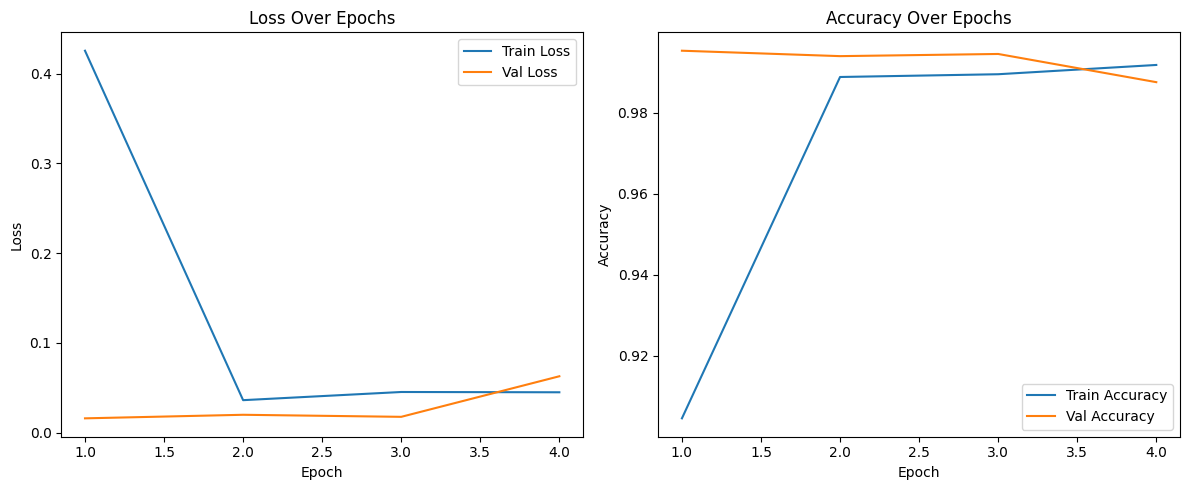

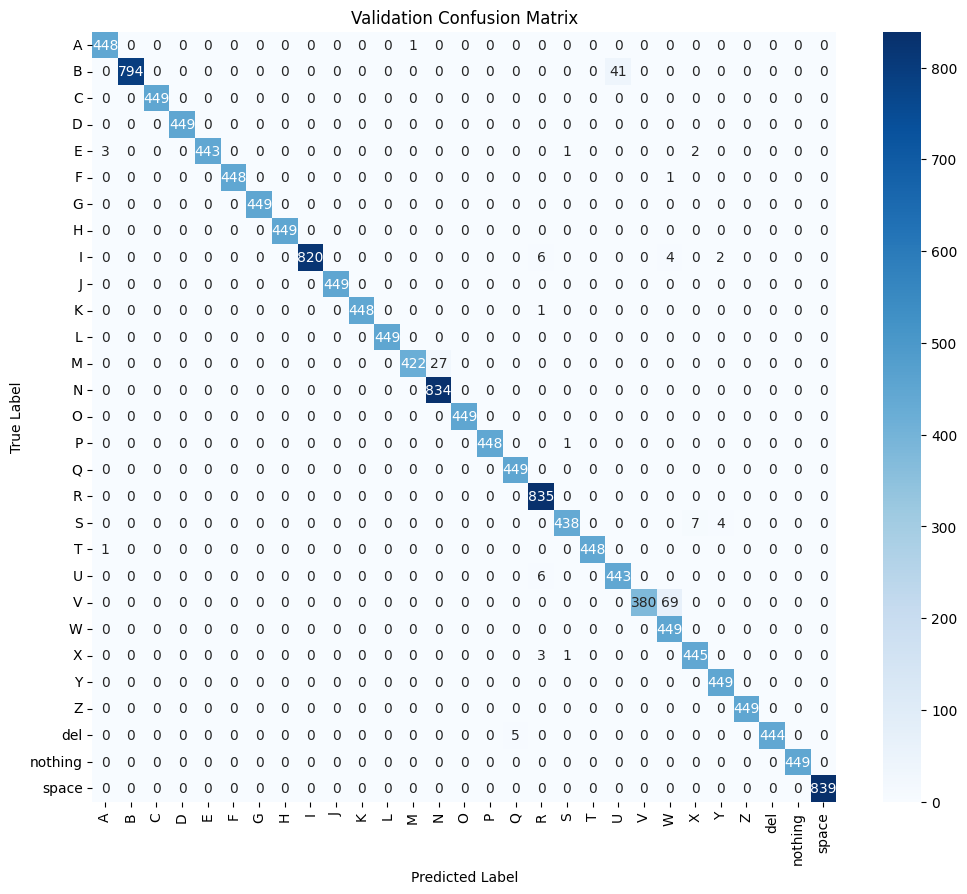


Validation Classification Report:
              precision    recall  f1-score   support

           A     0.9912    0.9978    0.9945       449
           B     1.0000    0.9509    0.9748       835
           C     1.0000    1.0000    1.0000       449
           D     1.0000    1.0000    1.0000       449
           E     1.0000    0.9866    0.9933       449
           F     1.0000    0.9978    0.9989       449
           G     1.0000    1.0000    1.0000       449
           H     1.0000    1.0000    1.0000       449
           I     1.0000    0.9856    0.9927       832
           J     1.0000    1.0000    1.0000       449
           K     1.0000    0.9978    0.9989       449
           L     1.0000    1.0000    1.0000       449
           M     0.9976    0.9399    0.9679       449
           N     0.9686    1.0000    0.9841       834
           O     1.0000    1.0000    1.0000       449
           P     1.0000    0.9978    0.9989       449
           Q     0.9890    1.0000    0.9945   

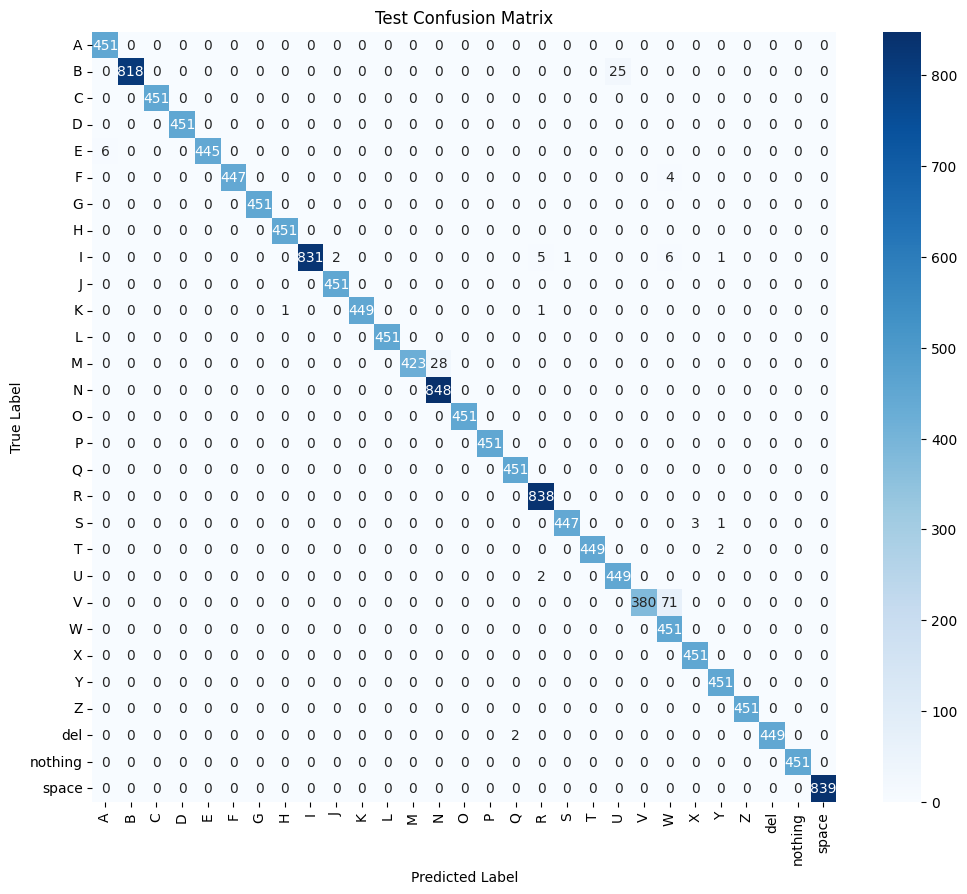


Test Classification Report:
              precision    recall  f1-score   support

           A     0.9869    1.0000    0.9934       451
           B     1.0000    0.9703    0.9849       843
           C     1.0000    1.0000    1.0000       451
           D     1.0000    1.0000    1.0000       451
           E     1.0000    0.9867    0.9933       451
           F     1.0000    0.9911    0.9955       451
           G     1.0000    1.0000    1.0000       451
           H     0.9978    1.0000    0.9989       451
           I     1.0000    0.9823    0.9911       846
           J     0.9956    1.0000    0.9978       451
           K     1.0000    0.9956    0.9978       451
           L     1.0000    1.0000    1.0000       451
           M     1.0000    0.9379    0.9680       451
           N     0.9680    1.0000    0.9838       848
           O     1.0000    1.0000    1.0000       451
           P     1.0000    1.0000    1.0000       451
           Q     0.9956    1.0000    0.9978       45

In [22]:
history = model.train_model(train_loader, val_loader)
model.evaluate_model(val_loader, split_name="Validation")
model.evaluate_model(test_loader, split_name="Test")
model.save("/kaggle/working/models/best_model_asl.pth")

In [33]:
model_path = '/kaggle/working/models/best_model_asl.pth'
print("Exist:", os.path.exists(model_path))
print("Size (bytes):", os.path.getsize(model_path))

Exist: True
Size (bytes): 16475478


In [34]:
!pip list | grep -E 'torch|torchvision|numpy|opencv-python|mediapipe|pillow|matplotlib|seaborn|scikit-learn|tqdm|timm'

matplotlib                         3.7.5
matplotlib-inline                  0.1.7
matplotlib-venn                    1.1.1
numpy                              1.26.4
opencv-python                      4.11.0.86
opencv-python-headless             4.11.0.86
pillow                             11.1.0
pytorch-ignite                     0.5.2
pytorch-lightning                  2.5.1
scikit-learn                       1.2.2
scikit-learn-intelex               2025.4.0
seaborn                            0.12.2
timm                               1.0.14
torch                              2.5.1+cu124
torchao                            0.10.0
torchaudio                         2.5.1+cu124
torchdata                          0.11.0
torchinfo                          1.8.0
torchmetrics                       1.7.1
torchsummary                       1.5.1
torchtune                          0.6.1
torchvision                        0.20.1+cu124
tqdm                               4.67.1
